# Set up

## Import

In [1]:
#import
import numpy as np
import pandas as pd

#system packages
import os
import glob
import pickle

#spatial packages
from rastertodataframe import raster_to_dataframe
from osgeo.gdalconst import *
from osgeo import gdal
from scipy.ndimage import gaussian_filter, median_filter

#visualization
import matplotlib.pyplot as plt
from matplotlib import cm

#processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster

#modeling
from sklearn import svm, datasets
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

#evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, balanced_accuracy_score

#misc
from math import floor
from itertools import product
from copy import deepcopy

In [2]:
#import custom functions
from custom_functions import *

## Download data

In [3]:
#load raws into dataframe
#Choose band to generate canny edge from, select None to skip edge generation
target_edge = 'B8A'
#defines canny edge sigma
sigma = 3

#run for all possible extents
sim_raws = gdal_to_dataframe('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif', calculate_edge = target_edge, sigma = sigma)
lab_raws = gdal_to_dataframe('../data_tests/labrador/raws', sigma = sigma)
james_raws = gdal_to_dataframe('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif', calculate_edge = target_edge, sigma = sigma)
tor_raws = gdal_to_dataframe('../data_tests/toronto/raws', calculate_edge = target_edge, sigma = sigma)
sjames_raws = gdal_to_dataframe('../data_tests/james_south/raws', calculate_edge = target_edge, sigma = sigma)
cal_raws = gdal_to_dataframe('../data_tests/calgary/raws', calculate_edge = target_edge, sigma = sigma)
trois_raws = gdal_to_dataframe('../data_tests/trois/raws', calculate_edge = target_edge, sigma = sigma)
winn_raws = gdal_to_dataframe('../data_tests/winnipeg/raws', calculate_edge = target_edge, sigma = sigma)
sask_raws = gdal_to_dataframe('../data_tests/sasketchewan/raws', calculate_edge = target_edge, sigma = sigma)
newf_raws = gdal_to_dataframe('../data_tests/newfoundland/raws', calculate_edge = target_edge, sigma = sigma)

getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge
getting edge


# EDA & Feature Selection

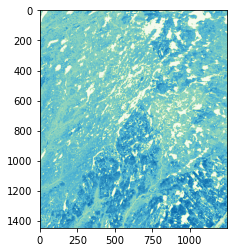

In [6]:
#plot example band
map_band = np.asarray(newf_raws['B8A'].values).reshape(1448, 1250)
plt.imshow(map_band, cmap= 'GnBu')

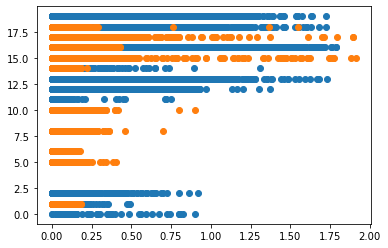

In [7]:
#comparing example band distribution within each class across two extents
plt.scatter(lab_raws['B01'], lab_raws.y)
plt.scatter(sim_raws['B01'], sim_raws.y)

## Geocoordinates

In [ ]:
#OPTIONAL: get geocoordinates
sim_raws['lat'], sim_raws['long'] = get_geocoord('../data_tests/simcoe_york/raws')
lab_raws['lat'], lab_raws['long'] = get_geocoord('../data_tests/labrador/raws')
tor_raws['lat'], tor_raws['long'] = get_geocoord('../data_tests/toronto/raws')
james_raws['lat'], james_raws['long'] = get_geocoord('../data_tests/james_bay/raws')
sjames_raws['lat'], sjames_raws['long'] = get_geocoord('../data_tests/james_south/raws')
cal_raws['lat'], cal_raws['long'] = get_geocoord('../data_tests/calgary/raws')
trois_raws['lat'], trois_raws['long'] = get_geocoord('../data_tests/trois/raws')
winn_raws['lat'], winn_raws['long'] = get_geocoord('../data_tests/winnipeg/raws')
sask_raws['lat'], sask_raws['long'] = get_geocoord('../data_tests/sasketchewan/raws')
newf_raws['lat'], newf_raws['long'] = get_geocoord('../data_tests/newfoundland/raws')

### K-means clustering

In [11]:
#visualize effect with test raws
test_raws = pd.concat([sim_raws, tor_raws, lab_raws, cal_raws, trois_raws, james_raws, sjames_raws])
test_raws = test_raws.drop('y', axis = 1)
test_raws = replace_values(test_raws)

#fit clustering
cl = cluster.KMeans(n_clusters=4, random_state = 0) # create an object of the classifier
param = cl.fit(test_raws) # train it
img_cl = cl.labels_ 

#select first image for visualization
img_sim = img_cl[:2500 * 2134].reshape(2134, 2500)

(-0.5, 2499.5, 2133.5, -0.5)

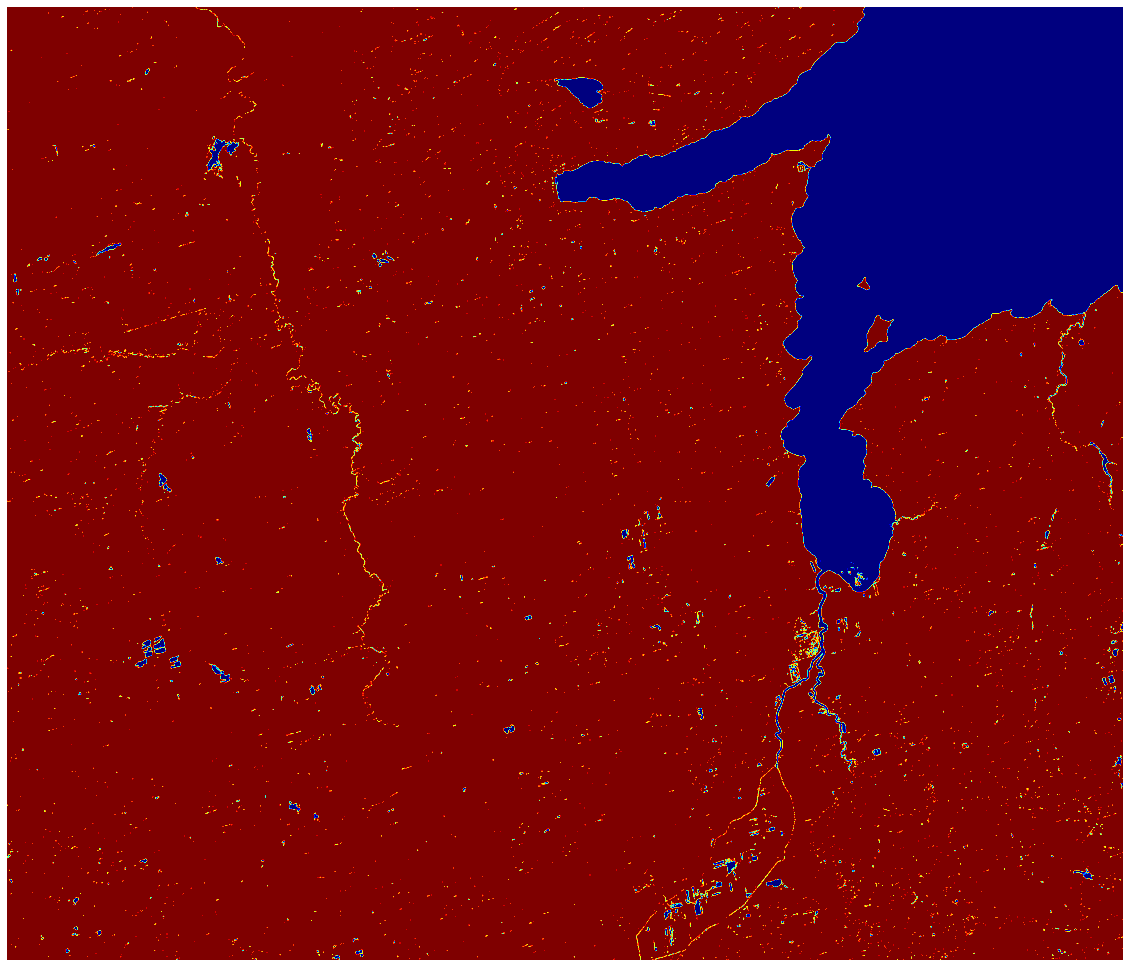

In [12]:
#visualize clustering using split images
plt.figure(figsize=[20,20])
plt.imshow(img_sim, cmap=cmap)
plt.axis('off')

### Outlier fixing

In [ ]:
#OPTIONAL: run to transform outliers on all raws

james_raws = outlier_fix(james_raws)
tor_raws = outlier_fix(tor_raws)
sim_raws = outlier_fix(sim_raws)
lab_raws = outlier_fix(lab_raws)
sjames_raws =  outlier_fix(sjames_raws)
trois_raws = outlier_fix(trois_raws)
cal_raws = outlier_fix(cal_raws)
winn_raws = outlier_fix(winn_raws)

In [ ]:
#OPTIONAL: run to add single column based on an outlier fix of another
#select target
target = f"{B01}f"

james_raws = add_fix_column(james_raws, target)
tor_raws= add_fix_column(tor_raws, target)
sim_raws = add_fix_column(sim_raws, target)
lab_raws = add_fix_column(lab_raws, target)
sjames_raws =  add_fix_column(sjames_raws, target)
trois_raws = add_fix_column(trois_raws, target)
cal_raws = add_fix_column(cal_raws, target)
winn_raws = add_fix_column(winn_raws, target)
sask_raws = add_fix_column(sask_raws, target)
newf_raws = add_fix_column(newf_raws, target)

In [ ]:
#Double check outlier fix
plt.scatter(james_raws['B01f'], james_raws['B02f'])

### Gaussian filtering

In [ ]:
#load gaussian filtered raws
sim_gauss = filter_raws('../data_tests/simcoe_york/raws', nrcan_name = 'Simcoe_York_2019.tif')
lab_gauss = filter_raws('../data_tests/labrador/raws')
james_gauss = filter_raws('../data_tests/james_bay/raws', nrcan_name = 'James_Bay_Med.tif')
tor_gauss = filter_raws('../data_tests/toronto/raws')
sjames_gauss = filter_raws('../data_tests/james_south/raws')
cal_gauss = filter_raws('../data_tests/calgary/raws')
trois_gauss = filter_raws('../data_tests/trois/raws')
winn_gauss = filter_raws('../data_tests/winnipeg/raws')

In [ ]:
#put together raw and filtered df of each scene
#create list of input images
train_raw = [tor_raws, sim_raws, lab_raws, cal_raws, james_raws, sjames_raws]
train_gauss = [tor_gauss, sim_gauss, lab_gauss, cal_raws, james_gauss, sjames_gauss]

#set empty main
main_dataframe = pd.DataFrame()

for i in range(len(train_raw)):
    #drop y from gauss
    temp_gauss = train_gauss[i].drop('y', axis = 1)
    #rename gauss columns
    gauss_names = [f'{name}g' for name in temp_gauss.columns]
    temp_gauss.columns = gauss_names
    #print(temp_gauss.head(), train_raw[i].head())
    
    #reset indices
    train_raw[i].reset_index(inplace=True, drop=True)
    temp_gauss.reset_index(inplace=True, drop=True)       
    new_df = pd.concat([train_raw[i], temp_gauss], axis = 1)
    #add to main
    main_dataframe = pd.concat([main_dataframe, new_df])

#drop edge gaussian column
main_dataframe = main_dataframe.iloc[:,:-1]
    
print(new_df.shape, lab_raws.shape)
main_dataframe.head()

### Combine extents

In [14]:
#NOTE: skip if filtered extents have been run
#vertical concat
main_dataframe = pd.concat([sim_raws, lab_raws, tor_raws, james_raws, sjames_raws])
main_dataframe = main_dataframe.reset_index().drop('index', axis = 1)
#main_dataframe = replace_values(main_dataframe) 

In [ ]:
#OPTIONAL: run to add cluster column
cl = cluster.KMeans(n_clusters = 4)
dataframe_copy = main_dataframe.drop('y', axis = 1)
param = cl.fit(dataframe_copy.astype('double'))
img_cl = cl.labels_
    
main_dataframe['clusters'] = img_cl    

In [ ]:
#OPTIONAL: pickle cluster model
pickle.dump(param, open('models/kcluster_13.sav', 'wb'))

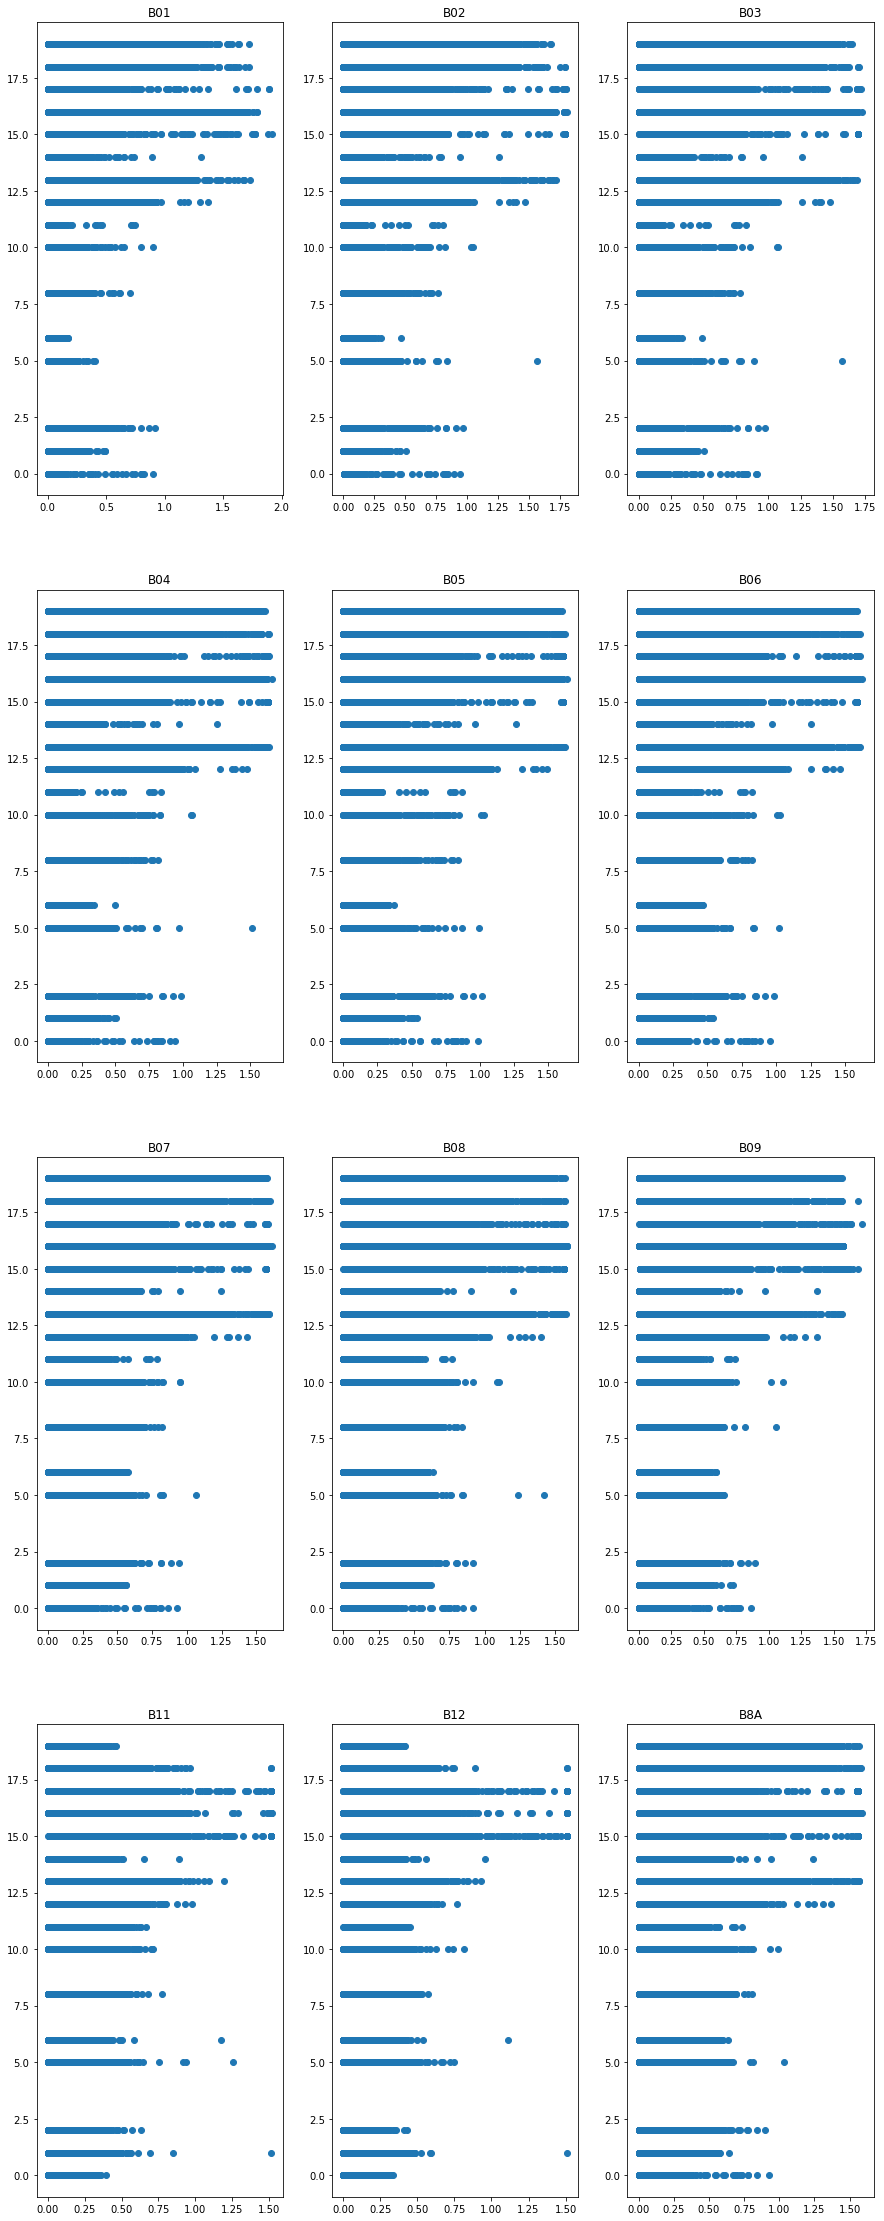

In [15]:
#Visulization of band distribution for each class in the main dataframe

#number of axes = number of possible combos
fig, axes = plt.subplots(4, 3, figsize = (15, 40))

for i, ax in enumerate(axes.flat):
    
    #index of columns
    X_scatter = main_dataframe[main_dataframe.columns[:-1][i]]
    Y_scatter = main_dataframe['y']
    
    # scatter current combination
    ax.scatter(X_scatter, Y_scatter)
    ax.set_title(main_dataframe.columns[i])

# Processing Data

### Calculated Layers

In [16]:
#OPTIONAL: run to calculate layers
main_dataframe = add_layers(main_dataframe)
#main_dataframe = add_extra_layers(main_dataframe) #add additional layers, uncomment to add
main_dataframe = replace_values(main_dataframe)

#only keep filtered bands
#main_dataframe = main_dataframe.iloc[:, 12:]

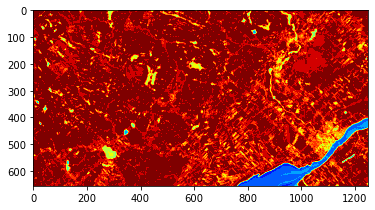

In [17]:
#preview calculated layers using example raw
test_plus = add_layers(trois_raws)
test_plus = replace_values(test_plus)

#preview calculated layers
map_band = np.asarray(test_plus['NDVI'].values).reshape(656, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
plt.imshow(map_band, cmap=cmap)

### Subsampling

In [18]:
#check features
main_dataframe.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'edge', 'y', 'NDVI', 'Moisture', 'NDWI', 'NDSI'],
      dtype='object')

In [19]:
#check dataframe shape and print class value counts
print(main_dataframe.shape)
main_classes = main_dataframe.value_counts('y').sort_index() 
print(main_classes)

(10877500, 18)
y 
0      181478
1     1032782
2      293740
5      761152
6      426506
8      667272
10     105105
11     165666
12     668171
13     631752
14     370027
15    3010586
16     495498
17     662078
18    1358567
19      47120
dtype: int64


In [ ]:
#OPTIONAL: run to create a binary model by converting train and test to binary based on input class
main_dataframe = convert_binary(main_dataframe, 14)

In [20]:
#final clean
#drop 0
main_dataframe = main_dataframe.loc[main_dataframe.y != 0]

#select classes above threshold
threshold = 100000
top_classes = main_classes[main_classes > threshold].reset_index().y

#save dataframe subset of those classes
main_subset = main_dataframe.loc[main_dataframe['y'].isin(top_classes.values)]

#take smallest value rounded down to nearest 1000
smallest_class = int(floor(min(main_subset.value_counts('y').sort_index().values)/ 1000)) * 1000
#subsampling - comment out for full set
smallest_class = threshold

#take subset of each class equal to smallest class value
data = main_subset.groupby("y").sample(n=smallest_class, random_state=24)

#add on snow - uncomment if threshold > class total
snow_subset = main_dataframe.loc[main_dataframe.y == 19]
data = pd.concat([data, snow_subset])
polar_shrub_subset = main_dataframe.loc[main_dataframe.y == 11]
#data = pd.concat([data, polar_shrub_subset])


print(data.shape)
data.value_counts('y').sort_index()

(1447120, 18)


y 
1     100000
2     100000
5     100000
6     100000
8     100000
10    100000
11    100000
12    100000
13    100000
14    100000
15    100000
16    100000
17    100000
18    100000
19     47120
dtype: int64

In [ ]:
#OPTIONAL: save current data to csv
data.to_csv('../data_tests/version15.csv', index = False)

## Train test split

In [21]:
y = data.y
X = data.drop('y', axis = 1)

#Dimensionality reduction - replace X with X_pca and run to try
pca = PCA(n_components = 1)
pca.fit(X)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, train_size=0.8, random_state = 0)

[0.99490299]


In [ ]:
#OPTIONAL: run to scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)

# Modelling

In [23]:
#set up save path for images
confusion_path = 'evaluation/'

## Random Forest

0.6048081707114821


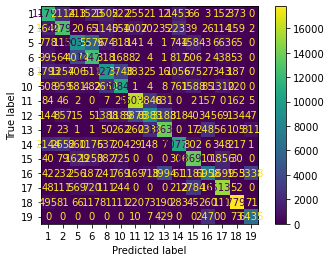

In [24]:
forest = RandomForestClassifier(random_state = 0, n_estimators = 300, max_depth = 15, max_features = 2).fit(X_train, y_train)
#get accuracy
forest_pred = forest.predict(X_test)
print(accuracy_score(y_test, forest_pred))

#plot confusion matrix
cm_forest = confusion_matrix(y_test, forest_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
cm_forest_fig.plot()

In [25]:
#make sure there's no overfit
forest_train_pred = forest.predict(X_train)
print(accuracy_score(y_train, forest_train_pred))

0.6376846771518603


In [26]:
#print feature importance
print_importance(forest, X_train)

          importance
edge        0.094987
NDVI        0.079541
NDSI        0.075122
NDWI        0.073546
B12         0.067489
B02         0.059106
B04         0.056730
B01         0.056189
B11         0.053296
Moisture    0.051798
B09         0.049301
B05         0.048476
B03         0.047636
B8A         0.047269
B08         0.046969
B07         0.046929
B06         0.045616


In [27]:
#show classification report
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           1       0.57      0.59      0.58     20000
           2       0.60      0.64      0.62     20000
           5       0.50      0.45      0.48     20000
           6       0.52      0.62      0.57     20000
           8       0.49      0.46      0.48     20000
          10       0.55      0.54      0.55     20000
          11       0.71      0.80      0.76     20000
          12       0.57      0.42      0.48     20000
          13       0.62      0.68      0.65     20000
          14       0.57      0.54      0.55     20000
          15       0.60      0.68      0.64     20000
          16       0.54      0.35      0.42     20000
          17       0.68      0.76      0.72     20000
          18       0.90      0.89      0.89     20000
          19       0.60      0.68      0.64      9424

    accuracy                           0.60    289424
   macro avg       0.60      0.61      0.60    289424
weighted avg       0.60   

In [ ]:
#OPTIONAL: save confusion matrix
#set subfolder for version
group_folder = 'base_run'
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'test_data/', 
                                           group_folder, 'forest.png'))

In [ ]:
#OPTIONAL: save model
pickle.dump(forest, open('../models/forest_14.sav', 'wb'))

### Demo test

In [28]:
#process demo test
X_demo, y_demo = process_data('../data_tests/demo_site.csv', '../data_tests/demo/raws', target_edge = 'B8A',
                 geocoords = False, target_outlier = False, edge_sigma = 3, gaussian = False, clustering = False, calculate_layers = True) 

getting edge


In [29]:
#make sure we have the right features
X_demo.columns

Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11',
       'B12', 'B8A', 'edge', 'NDVI', 'Moisture', 'NDWI', 'NDSI'],
      dtype='object')

In [ ]:
#OPTIONAL: binary conversion, run to test binary model
target_class = 14
y_demo = np.where(y_demo != target_class, 0, y_demo)
y_demo = np.where(y_demo == target_class, 1, y_demo)

In [ ]:
#OPTIONAL: load specific model
forest = pickle.load(open('models/forest_10.sav', 'rb'))

In [30]:
#generate predictions
demo_pred = forest.predict(X_demo)

In [ ]:
#OPTIONAL: with binary prediction, change prediction probability threshold
demo_pred = (forest.predict_proba(X_demo)[:,1] >= 0.6).astype(bool)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.42004042758087107
0.517431619047619


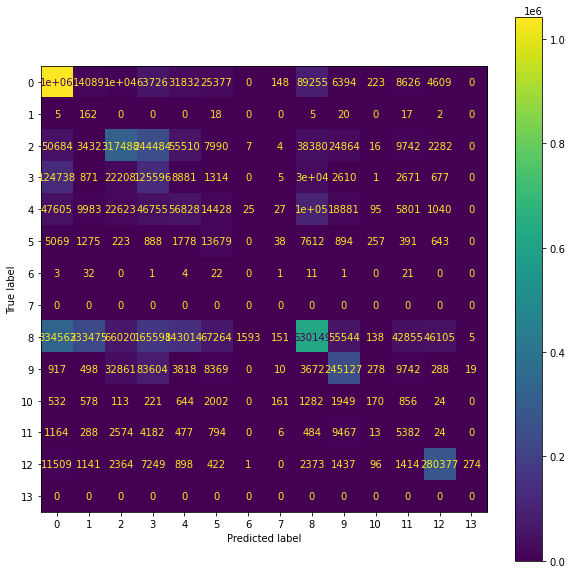

In [31]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [32]:
#show classification report
print(classification_report(y_demo, demo_pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.64      0.80      0.71   1295963
           2       0.00      0.71      0.00       229
           5       0.67      0.42      0.52    754883
           6       0.17      0.39      0.24    319587
           8       0.19      0.17      0.18    327876
          10       0.10      0.42      0.16     32747
          12       0.00      0.00      0.00        96
          13       0.00      0.00      0.00         0
          14       0.69      0.35      0.47   1786474
          15       0.67      0.63      0.65    389203
          16       0.13      0.02      0.03      8532
          17       0.06      0.22      0.10     24855
          18       0.83      0.91      0.87    309555
          19       0.00      0.00      0.00         0

    accuracy                           0.52   5250000
   macro avg       0.30      0.36      0.28   5250000
weighted avg       0.61      0.52      0.54   5250000



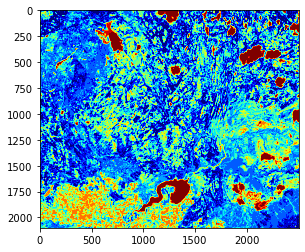

In [33]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap =demo_cmap)

In [ ]:
#OPTIONAL: save matrix and map as versions
#save confusion matrix
cm_forest_fig.figure_.savefig(os.path.join(confusion_path, 'demo/RFC', 'version_14.png'))

#save prediction map
prediction_map.figure.savefig(os.path.join(confusion_path, 'demo/RFC', 'map_14.png'))

In [ ]:
#Run to visualize true distribution of a single class
#create a copy
check_class_pred = deepcopy(demo_pred.values)

#replace classes 
check_class_pred = np.where(check_class_pred != 14, 0, check_class_pred)
check_class_pred = np.where(check_class_pred == 14, 1, check_class_pred)

In [44]:
X_demo['edge'].value_counts()

0    5195229
1      54771
Name: edge, dtype: int64

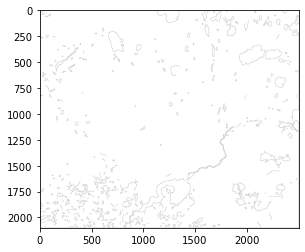

In [57]:
#plot feature or specific class
map_feat = np.asarray(X_demo['edge']).reshape(2100, 2500)
cmap = cm.get_cmap('jet', 15)    # set discrete

feature_map = plt.imshow(map_feat, vmin=0, vmax=1, cmap = 'binary')

### Random extent test

In [64]:
#process random extent
X_ran, y_ran = process_data(None, '../data_tests/newfoundland/raws', nrcan_name = 'NRCAN_transformed.tif', index = [-14, -11], target_edge = 'B8A',
                 geocoords = False, target_outlier = False, edge_sigma = 3, gaussian = False, clustering = False, calculate_layers = True) 

getting edge


In [65]:
#generate prediction
ran_pred = forest.predict(X_ran)

C:\Users\fynn\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


0.2410077562713104
0.3278917127071823


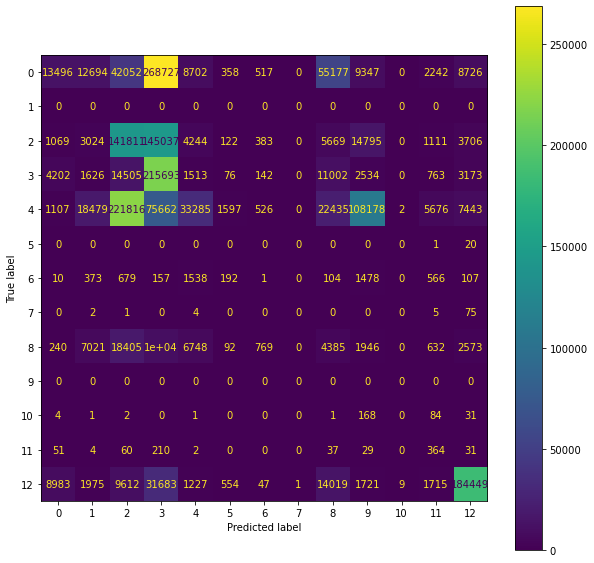

In [69]:
print(balanced_accuracy_score(y_ran, ran_pred))
print(accuracy_score(y_ran, ran_pred))

#confusion matrix
cm_forest = confusion_matrix(y_ran, ran_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

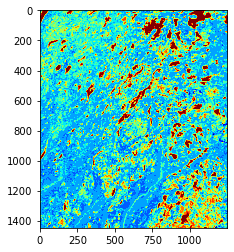

In [67]:
#display prediction map
map_pred = np.asarray(ran_pred).reshape(1448, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=cmap)

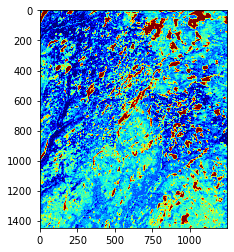

In [68]:
#true land cover class
map_pred = np.asarray(y_ran).reshape(1448, 1250)
cmap = cm.get_cmap('jet', 15)    # 11 discrete colors
plt.imshow(map_pred, cmap=cmap)

## XGBoost

Note: only works for creating binary models. The version of XGB in this notebook doesn't intake multi-class with missing values correctly. 

In [ ]:
xg_cl = xgb.XGBClassifier().fit(X_train, y_train)

#get accuracy
accuracy_xgb = xg_cl.score(X_test, y_test)
print(accuracy_xgb)

#plot confusion matrix
xgb_pred = xg_cl.predict(X_test)
cm_xgb = confusion_matrix(y_test, xgb_pred)
cm_xgb_fig = ConfusionMatrixDisplay(cm_xgb)
cm_xgb_fig.plot()

In [ ]:
#save
cm_xgb_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'xgb.png'), dpi = 300)

In [ ]:
X_demo['edge'] = X_test['edge'].astype('int')

#generate predictions
demo_pred = xg_cl.predict_proba(X_demo)

In [ ]:
demo_pred = xg_cl.predict(X_demo)

In [ ]:
#accuracy
print(balanced_accuracy_score(y_demo, demo_pred))
print(accuracy_score(y_demo, demo_pred))

#confusion matrix
cm_forest = confusion_matrix(y_demo, demo_pred)
cm_forest_fig = ConfusionMatrixDisplay(confusion_matrix = cm_forest, display_labels = forest.classes_)
fig, ax = plt.subplots(figsize=(10,10))
cm_forest_fig.plot(ax = ax)

In [ ]:
demo_pred = (xg_cl.predict_proba(X_demo)[:,1] >= 0.60).astype(bool)

In [ ]:
#plot demo prediction map
map_pred = np.asarray(demo_pred).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [ ]:
pickle.dump(forest, open('../models/xgb_bin14_v2.sav', 'wb'))

In [ ]:
#plot demo prediction map
map_pred = np.asarray(y_demo).reshape(2100, 2500)
demo_cmap = cm.get_cmap('jet', 2)    # 11 discrete colors
prediction_map = plt.imshow(map_pred, cmap=demo_cmap)

In [ ]:
X_demo['edge'].astype(int)

## SVC

In [ ]:
#NOTE: takes a long time to run

In [ ]:
#Different SVC kernels - sig performed less then 1 percent on subsample so its removed
#linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
#rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo').fit(X_train, y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)

In [ ]:
#predict from X_test
#linear_pred = linear.predict(X_test)
poly_pred = poly.predict(X_test)
#rbf_pred = rbf.predict(X_test)

In [ ]:
# retrieve the accuracy and print it for all 4 kernel functions
#accuracy_lin = linear.score(X_test, y_test)
accuracy_poly = poly.score(X_test, y_test)
#accuracy_rbf = rbf.score(X_test, y_test)

# creating a confusion matrix
#cm_lin = confusion_matrix(y_test, linear_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
#cm_rbf = confusion_matrix(y_test, rbf_pred)

#visual confusion matrix
#cm_lin_fig = ConfusionMatrixDisplay(confusion_matrix = cm_lin, display_labels = linear.classes_)
cm_poly_fig = ConfusionMatrixDisplay(confusion_matrix = cm_poly, display_labels = poly.classes_)
#cm_rbf_fig = ConfusionMatrixDisplay(confusion_matrix = cm_rbf, display_labels = rbf.classes_)

#print accuracy and confusion matrix
#print(accuracy_lin)
#cm_lin_fig.plot()
print(accuracy_poly)
cm_poly_fig.plot()
#print(accuracy_rbf)
#cm_rbf_fig.plot()

In [ ]:
#save confusion matrices
cm_lin_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'lin.png'), dpi = 300)
cm_poly_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'poly.png'), dpi = 300)
cm_rbf_fig.figure_.savefig(os.path.join(confusion_path, group_folder, 'rbf.png'), dpi = 300)